구글 코랩을 사용했습니다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 라이브러리 불러오기

In [ ]:
# 통계 모델들, fbprophet 설치
!pip install statsmodels==0.11.1
!pip install fbprophet

In [33]:
import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import warnings
import datetime
warnings.filterwarnings("ignore")

# 데이터 처리 및 확인 단계

처음에는 데이터를 확인하면서 주문량, 거래량 등 아래의 column 중 0값이 포함된 행은 완전히 삭제하거나, 중간 값으로 채워주는 등의 처리를 할려고 했습니다.
- (volume, trades, quote_av, tb_base_av, tb_quote_av) 

하지만 Prophet 모델만 사용하기로 결정한 후, 별다른 처리를 하지 않기로 했습니다.

In [4]:
# csv파일 읽어오기
path = '/content/drive/MyDrive/contest/bitcoin'
train_x_df = pd.read_csv(path  + "/train_x_df.csv")
train_y_df = pd.read_csv(path  + "/train_y_df.csv")
test_x_df = pd.read_csv(path  + "/test_x_df.csv")

In [5]:
print(f'train_x shape: {train_x_df.shape}')
print(f'train_y shape: {train_y_df.shape}')
print(f'test_x shape: {test_x_df.shape}')

train_x shape: (10159560, 12)
train_y shape: (883440, 12)
test_x shape: (730020, 12)


In [6]:
train_x_df.corr(method = "pearson")

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
sample_id,1.000000,0.000000e+00,4.278576e-03,-0.011692,-0.011690,-0.011662,-0.011676,-0.000407,0.010186,0.009696,-0.000393,0.009447
time,0.000000,1.000000e+00,3.894486e-18,-0.012273,-0.012346,-0.012248,-0.012289,-0.000277,-0.000464,-0.000708,-0.000444,-0.000394
coin_index,0.004279,3.894486e-18,1.000000e+00,-0.010498,-0.010721,-0.010341,-0.010520,0.006909,0.000136,0.010454,0.006393,-0.000206
open,-0.011692,-1.227325e-02,-1.049803e-02,1.000000,0.998631,0.999254,0.999071,0.009158,0.025290,0.022769,0.004867,0.019132
high,-0.011690,-1.234571e-02,-1.072102e-02,0.998631,1.000000,0.997830,0.998898,0.014944,0.033986,0.032518,0.011817,0.029751
low,-0.011662,-1.224846e-02,-1.034080e-02,0.999254,0.997830,1.000000,0.999315,0.002101,0.014780,0.011092,0.001434,0.012224
close,-0.011676,-1.228935e-02,-1.052042e-02,0.999071,0.998898,0.999315,1.000000,0.008074,0.024175,0.021432,0.007229,0.022276
volume,-0.000407,-2.768361e-04,6.909391e-03,0.009158,0.014944,0.002101,0.008074,1.000000,0.420857,0.573042,0.794751,0.372958
quote_av,0.010186,-4.641555e-04,1.357815e-04,0.025290,0.033986,0.014780,0.024175,0.420857,1.000000,0.826307,0.344711,0.920649
trades,0.009696,-7.075427e-04,1.045373e-02,0.022769,0.032518,0.011092,0.021432,0.573042,0.826307,1.000000,0.466903,0.754661


In [ ]:
print(train_x_df.head())
print('-------------------------------------------------------------')
print(train_x_df.tail())
print('-------------------------------------------------------------')
print(train_x_df.info())
print('-------------------------------------------------------------')
print(train_x_df.describe())
# print(train_x_df.isnull().sum()) NULL 값 없음 확인

In [ ]:
print(train_y_df.head())
print('-------------------------------------------------------------')
print(train_y_df.info())
print('-------------------------------------------------------------')
print(train_y_df.describe())
# print(train_y_df.isnull().sum()) NULL 값 없음 확인

In [ ]:
print(test_x_df.head())
print('-------------------------------------------------------------')
print(test_x_df.info())
print('-------------------------------------------------------------')
print(test_x_df.describe())
# print(test_x_df.isnull().sum()) NULL 값 없음 확인

In [10]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [11]:
# 함수 사용해서 3차원으로 변경
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

In [12]:
print(f'train_x_3d shape: {train_x_array.shape}')
print(f'train_y_3d shape: {train_y_array.shape}')
print(f'test_x_3d shape: {test_x_array.shape}')

train_x_3d shape: (7362, 1380, 10)
train_y_3d shape: (7362, 120, 10)
test_x_3d shape: (529, 1380, 10)


In [13]:
def plot_series(x_series, y_series):
    #입력 x_series와 출력 y_series를 연속적으로 연결하여 시각적으로 보여주기
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'black')
    plt.legend()

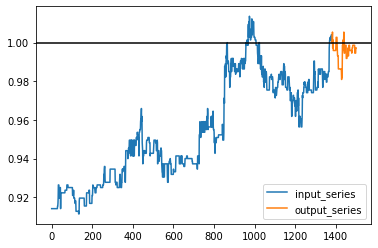

In [14]:
# sample_id n에 해당하는 sample의 분단위 시가 변동 정보 시각화
n = 1141
idx = n
plot_series(train_x_array[idx,:,1], train_y_array[idx,:,1])
plt.show()

# 모델 훈련


train 샘플에서 먼저, idx와 하이퍼파라미터를 변경해보며 실험했습니다.

모델이 상승과 하락의 %를 정확히 맞추는 것도 중요하지만, 상승과 하락의 순간만 잘 예측해도 돈을 잃지는 않을 것이라 판단했습니다.

따라서 실제 시가 변동과 예측한 시가 변동의 모양이 유사한지를 먼저 중점적으로 봤습니다.

In [15]:
start_time = '2021-01-31 00:00:00'
start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
print(start_dt)     

2021-01-31 00:00:00


In [16]:
idx = 523
x_series = train_x_array[idx,:,1]
y_series = train_y_array[idx,:,1]

In [17]:
# prophet 모델의 학습을 위한 가공 (ds, y 칼럼으로 구성)
x_df = pd.DataFrame()
x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
x_df['y'] = x_series.tolist() 

In [18]:
x_df.head()

,ds,y
0,2021-01-31 00:01:00,0.976734
1,2021-01-31 00:02:00,0.976877
2,2021-01-31 00:03:00,0.977020
3,2021-01-31 00:04:00,0.977448
4,2021-01-31 00:05:00,0.977020


In [19]:
model = Prophet(seasonality_mode='multiplicative',
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=False,
                  changepoint_range=0.97,  
                  changepoint_prior_scale=0.1  # 오버피팅, 언더피팅을 피하기 위해 조정
                )
model.add_seasonality(name='first_seasonality', period=1/12, fourier_order=7) # seasonality 추가
model.add_seasonality(name='second_seasonality', period=1/8, fourier_order=15) # seasonality 추가
model.fit(x_df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [20]:
# 120분 테스트 데이터를 예측
forecast = model.make_future_dataframe(periods=120, freq='min') # 120분을 예측
forecast_data = model.predict(forecast)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5) 

,ds,yhat,yhat_lower,yhat_upper
1495,2021-02-01 00:56:00,1.000002,0.974430,1.020771
1496,2021-02-01 00:57:00,0.999942,0.974331,1.021234
1497,2021-02-01 00:58:00,0.999876,0.975340,1.021965
1498,2021-02-01 00:59:00,0.999810,0.973700,1.022487
1499,2021-02-01 01:00:00,0.999749,0.974555,1.021963


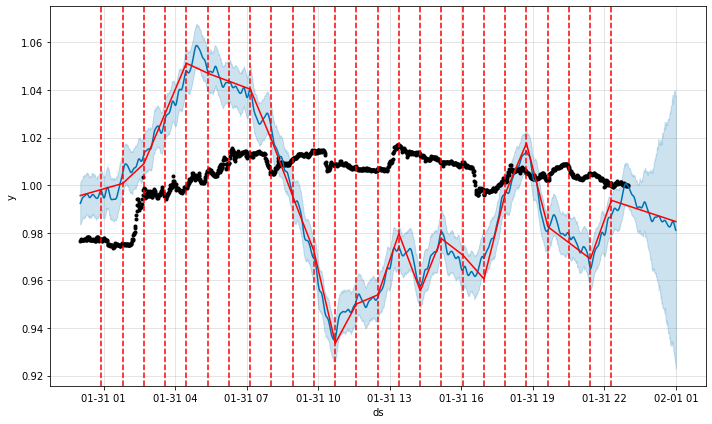

In [34]:
# 만들어진 데이터를 확인
fig1 = model.plot(forecast_data)
a = add_changepoints_to_plot(fig1.gca(), model, forecast_data)

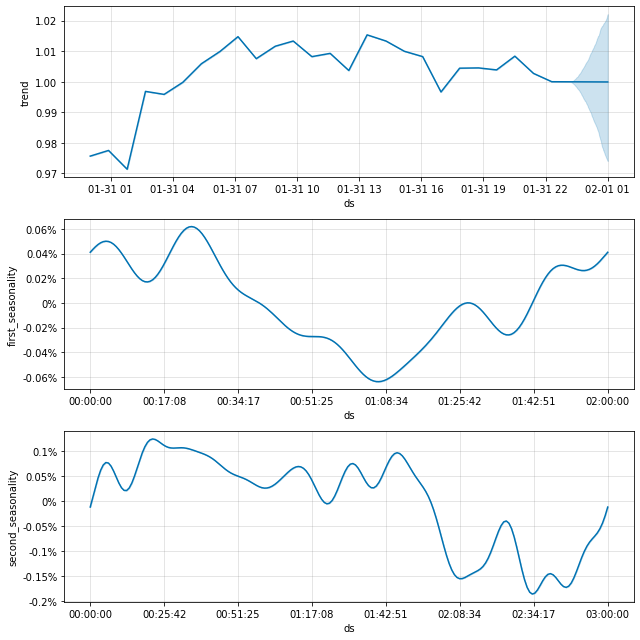

In [22]:
# 데이터 trend 및 추가한 seasonality 확인
fig2 = model.plot_components(forecast_data)

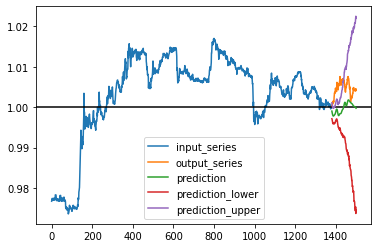

In [26]:
pred_y = forecast_data.yhat.values[-120:]
pred_y_lower = forecast_data.yhat_lower.values[-120:]
pred_y_upper = forecast_data.yhat_upper.values[-120:]

plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), pred_y, label = 'prediction')
plt.plot(np.arange(1380, 1380+120), pred_y_lower, label = 'prediction_lower')
plt.plot(np.arange(1380, 1380+120), pred_y_upper, label = 'prediction_upper')
plt.legend()
plt.show()

In [ ]:
# train 데이터 상단의 n개 샘플로 validation set를 구성하여 학습 및 추론
n = 300
valid_x_df = train_x_df[train_x_df.sample_id < n]
valid_y_df = train_y_df[train_y_df.sample_id < n]

valid_x_array = df2d_to_array3d(valid_x_df)
valid_y_array = df2d_to_array3d(valid_y_df)
valid_pred_array = np.zeros([n, 120])

In [ ]:
for idx in tqdm(range(valid_x_array.shape[0])):
    try:
        x_series = valid_x_array[idx,:,1]

        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()

        prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=False,
                  changepoint_range=0.97,  
                  changepoint_prior_scale=0.1  # 오버피팅, 언더피팅을 피하기 위해 조정
                  )
        prophet.add_seasonality(name='first_seasonality', period=1/12, fourier_order=7) # seasonality 추가
        prophet.add_seasonality(name='second_seasonality', period=1/8, fourier_order=15) # seasonality 추가
        prophet.fit(x_df)

        # 120분 테스트 데이터를 예측
        future_data = prophet.make_future_dataframe(periods=120, freq='min')
        forecast_data = prophet.predict(future_data)

        pred_y = forecast_data.yhat.values[-120:]
        pred_y_lower = forecast_data.yhat_lower.values[-120:]
        pred_y_upper = forecast_data.yhat_upper.values[-120:]

        valid_pred_array[idx,:] = pred_y
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass


대회의 특성상 안전하게 낮은 점수를 받는 것 보다,

 위험을 감수하고 큰 점수를 받는 것이 낫다고 판단해 100%의 매수 방식을 그대로 유지했습니다.

In [27]:
def array_to_submission(x_array, pred_array):
    # 입력 x_arrry와 출력 pred_arry를 통해서 
    # buy_quantitiy와 sell_time을 결정
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0.1
    
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
    buy_price = np.array(buy_price)
    # 6.5% 이상 상승으로 예측한 sample에 대해서만 100% 매수
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.065) * 1
    # 모델의 예측값 중 최대 값에 해당하는 시간에 매도
    submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    return submission

In [28]:
def df2d_to_answer(df_2d):
    # valid_y_df로부터
    # open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 
    # 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index


def COIN(y_df, submission, df2d_to_answer = df2d_to_answer):
    # 2차원 데이터프레임에서 open 시점 데이터만 추출하여 array로 복원
    # sample_id정보를 index에 저장
    y_array, index = df2d_to_answer(y_df)
    
    # index 기준으로 submission을 다시 선택
    submission = submission.set_index(submission.columns[0])
    submission = submission.iloc[index, :]    
    
    # 초기 투자 비용은 10000 달러
    total_momey      = 10000 # dollars
    total_momey_list = []
    
    # 가장 처음 sample_id값
    start_index = submission.index[0]
    for row_idx in submission.index:
        sell_time  = submission.loc[row_idx, 'sell_time']
        buy_price  = y_array[row_idx - start_index, 0]
        sell_price = y_array[row_idx - start_index, sell_time]
        buy_quantity = submission.loc[row_idx, 'buy_quantity'] * total_momey
        residual = total_momey - buy_quantity
        ratio = sell_price / buy_price
        total_momey = buy_quantity * ratio * 0.9995 * 0.9995 + residual        
        total_momey_list.append(total_momey)
        
    return total_momey, total_momey_list

In [29]:
test_pred_array = np.zeros([test_x_array.shape[0],
                           120])
for idx in tqdm(range(test_x_array.shape[0])):
    try:
        x_series = test_x_array[idx,:,1]

        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()
    
        prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=False,
                  changepoint_range=0.97,  
                  changepoint_prior_scale=0.1  # 오버피팅, 언더피팅을 피하기 위해 조정해준다.
                  )
        prophet.add_seasonality(name='first_seasonality', period=1/12, fourier_order=7) # seasonality 추가
        prophet.add_seasonality(name='second_seasonality', period=1/8, fourier_order=15) # seasonality 추가
        prophet.fit(x_df)

        # 120분 테스트 데이터를 예측
        future_data = prophet.make_future_dataframe(periods=120, freq='min')
        forecast_data = prophet.predict(future_data)

        pred_y = forecast_data.yhat.values[-120:]
        pred_y_lower = forecast_data.yhat_lower.values[-120:]
        pred_y_upper = forecast_data.yhat_upper.values[-120:]

        test_pred_array[idx,:] = pred_y
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

100%|██████████| 529/529 [50:44<00:00,  5.75s/it]


In [30]:
submission = array_to_submission(test_x_array, test_pred_array)

In [31]:
submission.to_csv('/content/drive/MyDrive/contest/bitcoin'+"/coin_submission.csv", index = False)

In [32]:
submission.buy_quantity.value_counts()

0    478
1     51
Name: buy_quantity, dtype: int64